# CNN Video Sentiment Analysis
This notebook will walk through the process of training a CNN to analyse frames of videos, and then take the aggregate over frames in a video.

In [1]:
import matplotlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import random
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os


In [2]:
# test code for converting from pytorch to keras


In [3]:
import wandb
from wandb.keras import WandbCallback
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: charlieisalright (use `wandb login --relogin` to force relogin)


True

In [5]:
# Setup the location of the various parameters needed

dataset = "../data/img_dataset/ravdess/"
epochs = 25


In [6]:
# One of RN18-FER+, RN18-MS, or RN50
EXPERIMENT = "RN50"


We use transfer learning, on top of the ResNet CNN, using frames extracted from our videos to get the specific model. In this case, we are training using data at 720p.

In [7]:
image_paths = list(paths.list_images(dataset))
data = []
labels = []

print("Processing {} images".format(len(image_paths)))


for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    
    # Load images, converting to RGB channels and scaling to 224 x 224
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    if EXPERIMENT in ['RN18-FER+', 'RN18-MS']:
        image = image.transpose(2,0,1)
    
    data.append(image)
    labels.append(label)
    
print("Done fetching images")
    
data = np.array(data)
labels = np.array(labels)

# One-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, 
                        test_size=0.25, stratify=labels, random_state=42)

# Randomly change the train set so results are more generalizable
        
if EXPERIMENT in ['RN18-FER+', 'RN18-MS']:
    data_format = 'channels_first'
else:
    data_format = 'channels_last'
train_augmentation = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    data_format=data_format)

val_augmentation = ImageDataGenerator(data_format=data_format)
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
train_augmentation.mean = mean
val_augmentation.mean = mean

Processing 5563 images
Done fetching images


In [ ]:
# serialize the label binarizer to disk
f = open("label_bin", "wb")
f.write(pickle.dumps(lb))
f.close()

In [ ]:
def get_RN50_model():
    base_model = ResNet50(weights="imagenet", include_top=False, 
                      input_tensor=Input(shape=(224, 224, 3)))

    head_model = base_model.output
    head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
    head_model = Flatten(name="flatten")(head_model)
    head_model = Dense(512, activation="relu")(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(len(lb.classes_), activation="softmax")(head_model)

    model = Model(inputs=base_model.input, outputs=head_model)

    # Ensure we don't train the base model
    for layer in base_model.layers:
        layer.trainable = False
        
    return model

def get_fer_model():
    # TODO work out the input shape here!
    base_model = load_model('../models/fan-fer', compile=False)
    base_model._layers.pop()
    base_model._layers.pop()
    base_model._layers.pop()
    base_model._layers.pop()
    base_model._layers.pop()
    base_model._layers.pop()
    
    head_model = base_model.layers[-1].output
    head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
    head_model = Flatten(name="flatten")(head_model)
    head_model = Dense(512, activation="relu")(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(len(lb.classes_), activation="softmax")(head_model)

    model = Model(inputs=base_model.input, outputs=head_model)
    
    # Ensure we don't train the base model
    for layer in base_model.layers:
        layer.trainable = False
    return model


def get_ms1m_model():
    base_model = load_model('../models/fan-ms1m', compile=False)
    base_model._layers.pop()
    base_model._layers.pop()
    base_model._layers.pop()
    base_model._layers.pop()
    base_model._layers.pop()
    base_model._layers.pop()
    
    head_model = base_model.layers[-1].output
    head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
    head_model = Flatten(name="flatten")(head_model)
    head_model = Dense(512, activation="relu")(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(len(lb.classes_), activation="softmax")(head_model)

    model = Model(inputs=base_model.input, outputs=head_model)
    
    # Ensure we don't train the base model
    for layer in base_model.layers:
        layer.trainable = False
    return model

def get_model():
    if EXPERIMENT == "RN18-FER+":
        return get_fer_model()

    elif EXPERIMENT == "RN18-MS":
        return get_ms1m_model()
    
    elif EXPERIMENT == "RN50":
        return get_RN50_model()
    
    else:
        raise ValueError("Invalid EXPERIMENT setting : {}".format(EXPERIMENT))

In [ ]:
def train():
    # default hyperparameters
    config_defaults = {
        'batch_size' : 31,
        'learning_rate' : 0.0008475,
        'epochs': 49
    }

    wandb.init(project='sentiment', entity='charlieisalright', config=config_defaults)
    config = wandb.config
    
    config.architecture_name = "ResNet18"
    config.dataset = "ms1m"
    
    # Compile the model, using stochastic gradient descent optimization.
    opt = SGD(lr=config.learning_rate, momentum=0.9, decay=1e-4 / config.epochs)
    model = get_model()
    model.compile(loss="categorical_crossentropy", optimizer=opt,
        metrics=["accuracy"])

    # Now we can start training!
    H = model.fit(
        x = train_augmentation.flow(trainX, trainY, batch_size=config.batch_size),
        steps_per_epoch = len(trainX) // config.batch_size,
        validation_data = val_augmentation.flow(testX, testY),
        validation_steps = len(testX) // config.batch_size,
        epochs = config.epochs,
        callbacks = [WandbCallback()]
    )


Next, we setup a sweep of hyperparameters.

In [ ]:
train()

In [ ]:
sweep_config = {
    "method": "bayes",
    "metric": {
        "name": "val_loss",
        "goal": "minimize"
    },
    "parameters":{
        "epochs": {
            "distribution": "int_uniform",
            "min": 13,
            "max": 50
        },
        "batch_size": {
            "distribution": "int_uniform",
            "min": 4,
            "max": 64
        },
        "learning_rate": {
            "distribution": "uniform",
            "min": 0.00001,
            "max": 0.01
        }
    }
}
sweep_id = 'ocuhuuax' #wandb.sweep(sweep_config, project='sentiment')
wandb.agent(sweep_id, project='sentiment', function=train)

Finally, evaluate the network, and plot some results.

In [8]:
model = load_model("../models/best-models/resnet50.h5")

predictions = model.predict(x=testX.astype("float32"), batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))



              precision    recall  f1-score   support

       angry       0.48      0.63      0.55       190
        calm       0.55      0.41      0.47       189
     disgust       0.44      0.63      0.52       193
     fearful       0.40      0.49      0.45       180
       happy       0.61      0.78      0.68       185
     neutral       0.62      0.11      0.19        89
         sad       0.41      0.29      0.34       188
   surprised       0.39      0.26      0.31       177

    accuracy                           0.48      1391
   macro avg       0.49      0.45      0.44      1391
weighted avg       0.48      0.48      0.46      1391



In [ ]:
# Plot confusion matrix


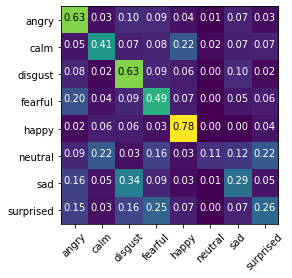

In [22]:
from sklearn.metrics import confusion_matrix
import itertools

matrix = confusion_matrix(testY.argmax(axis=1), predictions.argmax(axis=1), normalize='true')

plt.imshow(matrix, interpolation="nearest")

target_names = lb.classes_
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)


thresh = matrix.max() / 1.5
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
    plt.text(j, i, "{:0.2f}".format(matrix[i, j]),
             horizontalalignment="center",
             color="white" if matrix[i, j] < thresh else "black")

## NOTES
This works but provides accuracy of only about 0.3 ish. Next thing to try is using a face details model first!!!